# SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper We're replecating (the source of the dataset that I will be using) is avaible here: https://arxiv.org/abs/1710.06071

And reading throug the paper above, We see that the model architecture that they use to achieve their bert results is avaible here: https://arxiv.org/abs/1612.05251

## GPU confirmation

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a40a223a-dc6b-7747-4df4-110076990772)


## Get data

Since We'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 15.20 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20k dataset

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all the file names in the target directory

import os

filenames = [data_dir + filename for filename in os.listdir(data_dir) ]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data, let's write a function to read in all of the lines of a target text fike.

In [ ]:
# Create function to read the lines of a document

def get_lines(filename):
  """
  Read filenames (a text filename) and return the lines of test as a list.

  Args:
    filename (str): a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename
  """

  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the lines with the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

The data representation for the model:

```
[{'line_number':0,
  'target':'BACKGROUND',
  'text': "Emotional eating is associated with overeating and the development of obesity .\n"
  'total_lines': 11},
  ...]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.

  """

  input_lines = get_lines(filename) #get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  #Loop
  for line in input_lines:
    if line.startswith("###"): #check to see if the is an ID line
      abstract_id = line
      abstract_lines = ""  #reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() #split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() #get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines aree in the target abstract?  (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples listr

    else: # if the above conditions are not fulfilled, the line contains a labelled sentence
      abstract_lines += line
  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt") #dev is an other name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 569 ms, sys: 97.1 ms, total: 667 ms
Wall time: 1.66 s


In [ ]:
# check the firts abstract of our training data
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into DataFrame to further visualize it?

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

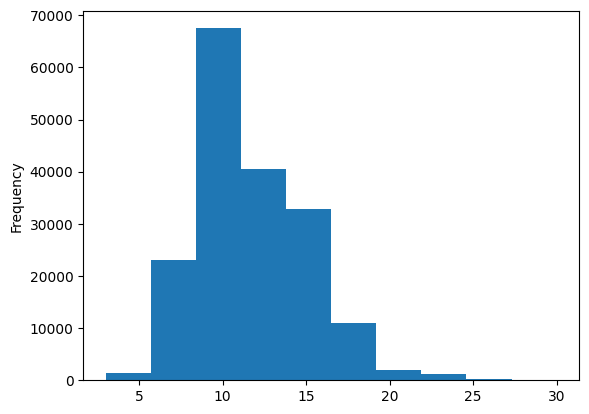

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get list of sentences


In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # Sparse matrix are not compatible with tf
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1)) # We only only need top use the transform method because our one code encoder was fitted with the train data
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
#check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

#Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LAbelEncoder instances
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling Experiments

We're going to be trying out a bunch of different models and seeing which works best

### Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
# Create a Pipeline

model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

# Fit the pipeline to the training data

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
# Download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-06-18 20:04:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-06-18 20:04:46 (17.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Data Preprocessing

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [ ]:
# Find the average number of tokens in the train sentences
sentence_lens = [len(i.split()) for i in train_sentences]
avg_sentence_len = np.round(np.mean(sentence_lens))
avg_sentence_len

np.float64(26.0)

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

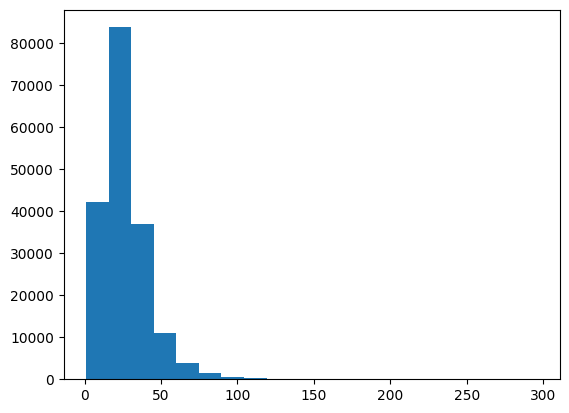

In [ ]:
# Distribution of the sentences lens
import matplotlib.pyplot as plt
plt.hist(sentence_lens,bins=20)

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sentence_lens,95))
output_seq_len

55

In [ ]:
# Max sequence length in thwe training set
max(sentence_lens)

296

### Text vectorization layer

A layer whichs maps our texts data from words to numbers.

In [ ]:
#How many words are in our vocab? (take from table 2: https://arxiv.org/abs/1710.06071)
max_tokens = 68000

In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens = max_tokens, #number of word of vocabulary
    output_mode = "int",
    output_sequence_length = output_seq_len) #desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentence
import numpy as np
random_sentence = np.random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nLength of text: {len(random_sentence.split())}\
      \n\nVectorized version:\n {text_vectorizer([random_sentence])}")


Original text:
 three patients after cik reinfusion had transient fever , and @ cases felt pain in the lower limb , but the symptoms were relieved after symptomatic treatment .      

Length of text: 28      

Vectorized version:
 [[  134    12    21 12758 13011    55  1816  2348     3   263  4711    65
      5     2   105  1349    72     2   144     9  8821    21   884    19
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

print(f"Number of words in the vocabulary: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in the vocabulary: 64841
5 most common words: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]
5 least common words: [np.str_('aainduced'), np.str_('aaigroup'), np.str_('aachener'), np.str_('aachen'), np.str_('aaacp')]


In [ ]:
# Get text vecotrizer configuration
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create a custom text embedding

> Mask is a concept in the field of Deep Learning that involves selectively hiding or blocking certain parts of an input or output, allowing a neural network to focus on specific areas of interest

In [ ]:
embedding = layers.Embedding(
    input_dim = len(words_in_vocab),
    output_dim = 128,
    mask_zero = True, #use masking to handle variable sequence lengths (save space)
    embeddings_initializer = "uniform",
    name = "embedding"
)

In [ ]:
# Get a random sentences and its embedding form
random_sentence = np.random.choice(train_sentences)
print(f"Original sentence: {random_sentence}\
        \n\n Embedding version: {embedding(text_vectorizer([random_sentence]))}")

Original sentence: these data suggest that glp-@ does not act as a direct vasodilator in humans and does not contribute to sympathetic activation .        

 Embedding version: [[[-0.01520804 -0.01698449  0.02219558 ... -0.02697983  0.04596767
    0.02337589]
  [ 0.04979947  0.00986496 -0.00776704 ... -0.02376864 -0.04396639
   -0.04667   ]
  [ 0.02736348 -0.04920153 -0.0294031  ...  0.04333467  0.00827978
    0.02966353]
  ...
  [-0.03219735  0.01698083 -0.04406194 ...  0.00655679 -0.02962211
    0.00143846]
  [-0.03219735  0.01698083 -0.04406194 ...  0.00655679 -0.02962211
    0.00143846]
  [-0.03219735  0.01698083 -0.04406194 ...  0.00655679 -0.02962211
    0.00143846]]]


## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into TensorFlow datasets
train_dataset =  tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Build a 1d Convolutional neural network
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.Conv1D(filters=64,kernel_size=5,padding="same",activation="relu")(x)
print(x.shape)
x = layers.GlobalMaxPool1D()(x)
print(x.shape)
outputs = layers.Dense(5,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs,name="model_1_Conv1D")

(None, 55, 128)
(None, 55, 64)
(None, 64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_sentences_array = np.array(train_sentences)

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=(0.0*len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5634 - loss: 1.0966 - val_accuracy: 0.7807 - val_loss: 0.6011
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7837 - loss: 0.5911 - val_accuracy: 0.7984 - val_loss: 0.5422
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7974 - loss: 0.5441 - val_accuracy: 0.8057 - val_loss: 0.5241


In [ ]:
# Evaluate onn whole validation set
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8071 - loss: 0.5206


[0.5241199135780334, 0.8056732416152954]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)

model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


(array([[6.12575054e-01, 1.00245945e-01, 1.59688748e-03, 2.82259583e-01,
         3.32257990e-03],
        [2.40409166e-01, 6.02458775e-01, 8.15755688e-04, 1.50830314e-01,
         5.48600359e-03],
        [1.89751670e-01, 3.08773834e-02, 1.38779113e-03, 7.77769804e-01,
         2.13367864e-04],
        ...,
        [4.15482238e-04, 2.19214102e-03, 2.50263363e-02, 2.86717172e-04,
         9.72079337e-01],
        [2.92878021e-02, 3.88599008e-01, 7.68049136e-02, 3.00107207e-02,
         4.75297540e-01],
        [2.66454332e-02, 9.66303945e-01, 1.33200467e-03, 3.32656573e-03,
         2.39211763e-03]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes

model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.56732424202305,
 'precision': 0.8046932759492298,
 'recall': 0.8056732424202304,
 'f1': 0.8043006927209564}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretainred word embedding from Kaggle, more specifically the universal sentence encoder: https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub # Import tensorflow_hub

In [ ]:
class USELayer(layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)
        self.embedding_layer = hub.KerasLayer(
            "https://tfhub.dev/google/universal-sentence-encoder/4",
            dtype=tf.string,
            trainable=False
        )

    def call(self, inputs):
        return self.embedding_layer(inputs)

In [ ]:
# Test out the pretrained embedding on a random sentence
random_training_sentence = np.random.choice(train_sentences)
print(f"Random sentence:\n {random_training_sentence}")
use_embedded_sentece = USELayer()([random_training_sentence])
print(f"Embedded sentence:\n {use_embedded_sentece[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentece[0])}")

Random sentence:
 group i was injected @ mg of methylprednisolone acetate into the masseter muscle via the intrabuccal approach , one hour before the surgery .
Embedded sentence:
 [-0.04088828  0.02309022  0.04026635 -0.04485923 -0.0046788   0.04465054
  0.03260636  0.02703987  0.04602394  0.0533879   0.07726368  0.01679844
  0.02658099  0.07549108 -0.01712433 -0.00302096 -0.08531592 -0.03616337
 -0.03257456  0.07571604 -0.0618456  -0.0327222  -0.00743358 -0.02980861
  0.043565   -0.0572582   0.05802299  0.03083609 -0.02727672 -0.02293534]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings from Kaggle

In [ ]:
# Define feature extraction model using TF hub layer
inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embedding = USELayer()(inputs)
x = layers.Dense(128,activation="relu")(pretrained_embedding)
outputs = layers.Dense(5,activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,outputs=outputs,
                          name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"],
                  jit_compile=False)

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use_layer_1 (USELayer)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5740 - loss: 1.1040 - val_accuracy: 0.6915 - val_loss: 0.7970
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7023 - loss: 0.7720 - val_accuracy: 0.7068 - val_loss: 0.7542
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7135 - loss: 0.7560 - val_accuracy: 0.7121 - val_loss: 0.7383


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7122 - loss: 0.7399


[0.7416754961013794, 0.7127300500869751]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step


array([[0.41147393, 0.38374382, 0.00271687, 0.19297932, 0.009086  ],
       [0.31450635, 0.53043634, 0.00461598, 0.14718322, 0.00325807],
       [0.26108623, 0.13518448, 0.01645349, 0.5497833 , 0.03749244],
       ...,
       [0.00232524, 0.00670394, 0.06319451, 0.00101318, 0.92676306],
       [0.00383106, 0.05043519, 0.17645709, 0.00135743, 0.7679192 ],
       [0.16614237, 0.23041315, 0.5231503 , 0.00817408, 0.07212001]],
      dtype=float32)

In [ ]:
# Convert the prediction probabilities found  with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
model_2_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 71.2730041043294,
 'precision': 0.712908674629194,
 'recall': 0.7127300410432941,
 'f1': 0.7097898876637102}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previusly we've token-level embeddings, but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
random_training_sentence = np.random.choice(train_sentences)

In [ ]:
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'o n   m u l t i v a r i a b l e   l o g i s t i c   r e g r e s s i o n   a n a l y s i s   ,   m e a n   d c i   c a r r i e d   a n   o d d s   r a t i o   o f   @   (   @   %   c o n f i d e n c e   i n t e r v a l   (   c i   )   :   @ - @   @   ;   p   =   @   )   p e r   @   k c a l   i n c r e a s e   f o r   @ - d a y   m o r t a l i t y   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average chracter length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

np.float64(149.3662574983337)

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

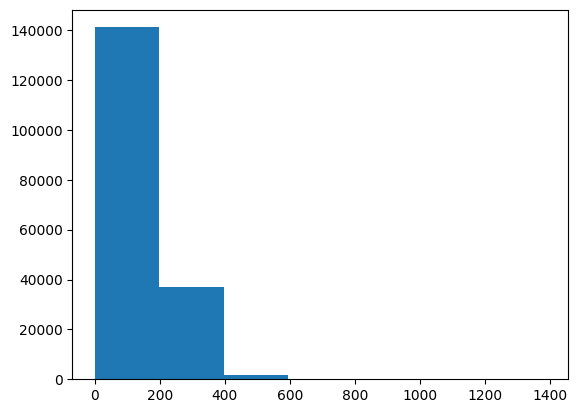

In [ ]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7)

In [ ]:
#Fin what character length covers 95% of sequence
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKEN = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, [UNK])
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKEN,
                                           output_sequence_length=output_seq_char_len,
                                           name="char_vectorizer")

In [ ]:
# Adapt  character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters : {char_vocab[:5]}")
print(f"5 least common characters : {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters : ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i')]
5 least common characters : [np.str_('k'), np.str_('x'), np.str_('z'), np.str_('q'), np.str_('j')]


In [ ]:
# Test out character vectorizer
random_train_chars = np.random.choice(train_chars)
print(f"Charified text: \n{random_train_chars.split()}")
print(f"Length of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars: \n{vectorized_chars}")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text: 
['s', 'y', 'm', 'p', 't', 'o', 'm', 's', 'a', 'n', 'd', 'f', 'u', 'n', 'c', 't', 'i', 'o', 'n', 'i', 'n', 'g', 'i', 'm', 'p', 'r', 'o', 'v', 'e', 'd', 'w', 'i', 't', 'h', 'a', 'o', 'm', '@', 'm', 'g', 'v', 'e', 'r', 's', 'u', 's', 'p', 'l', 'a', 'c', 'e', 'b', 'o', 'i', 'n', 'p', 'a', 't', 'i', 'e', 'n', 't', 's', 'w', 'i', 't', 'h', 'a', 'c', 'u', 't', 'e', 's', 'c', 'h', 'i', 'z', 'o', 'p', 'h', 'r', 'e', 'n', 'i', 'a', ',', 'w', 'i', 't', 'h', 'a', 'c', 'c', 'e', 'p', 't', 'a', 'b', 'l', 'e', 's', 'a', 'f', 'e', 't', 'y', 'a', 'n', 'd', 't', 'o', 'l', 'e', 'r', 'a', 'b', 'i', 'l', 'i', 't', 'y', '.']
Length of random_train_chars: 285
Vectorized chars: 
[[ 9 19 15 14  3  7 15  9  5  6 10 17 16  6 11  3  4  7  6  4  6 18  4 15
  14  8  7 21  2 10 20  4  3 13  5  7 15 15 18 21  2  8  9 16  9 14 12  5
  11  2 22  7  4  6 14  5  3  4  2  6  3  9 20  4  3 13  5 11 16  3  2  9
  11 13  4 25  7 14 13  8  2  6  4  5 20  4  3 13  5 11 11  2 14  3  5 22
  12  2  9  5 17  2  3 

### Creating a characther-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), #number of different characters
                             output_dim = 25, # this is the size of the char embedding in the paper
                              mask_zero = False,
                              name="char_embed")

In [ ]:
# test our character embedding layer
print(f"Charified text:\n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorized and embedded):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 s y m p t o m s   a n d   f u n c t i o n i n g   i m p r o v e d   w i t h   a o m   @   m g   v e r s u s   p l a c e b o   i n   p a t i e n t s   w i t h   a c u t e   s c h i z o p h r e n i a   ,   w i t h   a c c e p t a b l e   s a f e t y   a n d   t o l e r a b i l i t y   .
Embedded chars (after vectorized and embedded):
 [[[ 1.0148324e-02  3.0643705e-02  4.9506500e-04 ...  4.3829333e-02
    1.0843646e-02  1.1372197e-02]
  [-2.7483702e-02  3.9634611e-02  1.3403926e-02 ...  1.9122493e-02
   -5.4026619e-03  2.3455951e-02]
  [-4.1172408e-02  3.2043520e-02  2.5993142e-02 ...  4.8086159e-03
   -3.6178008e-03  1.2028802e-02]
  ...
  [-4.1092135e-02 -5.1696897e-03 -1.7112315e-02 ... -1.4156796e-02
   -9.5807016e-05 -5.6689978e-03]
  [-4.1092135e-02 -5.1696897e-03 -1.7112315e-02 ... -1.4156796e-02
   -9.5807016e-05 -5.6689978e-03]
  [-4.1092135e-02 -5.1696897e-03 -1.7112315e-02 ... -1.4156796e-02
   -9.5807016e-05 -5.6689978e-03]]]

Character embedding shape: (1, 29

In [ ]:
len(random_train_chars)

285

### Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on char only

inputs = layers.Input(shape=(),dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters=64,kernel_size=5,padding="same",activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5,activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="odel_3_conv1d_char_embeddings")

#Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

**Warning note:** The Masking layer expects every downstream layer to support masking, which is not the case of the Conv1D layer. There is another way to apply masking, using the Functional API:

Used before a CONV1D usign a RNN not apply in a Conv1D directly
```
inputs = Input(...)
mask = Masking().compute_mask(inputs) # <= Compute the mask
embed = Embedding(...)(inputs)
lstm = LSTM(...)(embed, mask=mask) # <= Apply the mask
conv = Conv1D(...)(lstm)
...
model = Model(inputs=[inputs], outputs=[...])
```

In [ ]:
# Summary
model_3.summary()

Model: "odel_3_conv1d_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Created char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4191 - loss: 1.3999 - val_accuracy: 0.6007 - val_loss: 1.0206
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6012 - loss: 1.0054 - val_accuracy: 0.6449 - val_loss: 0.9177
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6437 - loss: 0.9113 - val_accuracy: 0.6586 - val_loss: 0.8627


In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


array([[0.18907395, 0.39792955, 0.07099113, 0.3181618 , 0.02384359],
       [0.11435308, 0.34984183, 0.02094582, 0.50525856, 0.00960073],
       [0.12068509, 0.13640992, 0.14198603, 0.58983004, 0.01108889],
       ...,
       [0.04372048, 0.05194579, 0.1270296 , 0.05545291, 0.7218512 ],
       [0.06560715, 0.16140035, 0.3408248 , 0.07869703, 0.35347065],
       [0.3146929 , 0.51031846, 0.06566738, 0.10313642, 0.00618486]],
      dtype=float32)

In [ ]:
# Convert predictiopn probabilties to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate the results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 66.54640540182709,
 'precision': 0.6633591184221727,
 'recall': 0.6654640540182709,
 'f1': 0.6543619237215273}

## Model 4 : Combining pretrained token embedding + character embedding (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similare to `model_3`with a slight modification
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to figure 1 and section 4.2 of the paper used as model
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model
import keras
@keras.saving.register_keras_serializable()
class USELayer(layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)
        self.embedding_layer = hub.KerasLayer(
            "https://tfhub.dev/google/universal-sentence-encoder/4",
            dtype=tf.string,
            trainable=False
        )

    def call(self, inputs):
        return self.embedding_layer(inputs)

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_inputs")
token_embeddings = USELayer()(token_inputs)
token_outputs = layers.Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,),dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 4. Create output layersd - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5,activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [ ]:
# Get a summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_inputs         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_inputs        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_inputs[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ use_layer_2         │ (None, 512)       │          0 │ token_inputs[0][… │
│ (USELayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ use_layer_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 48)        │      9,600 │ char_embed[1][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 176)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 176)       │          0 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     22,656 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 5)         │        645 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,265 (387.75 KB)

 Trainable params: 99,265 (387.75 KB)

 Non-trainable params: 0 (0.00 B)

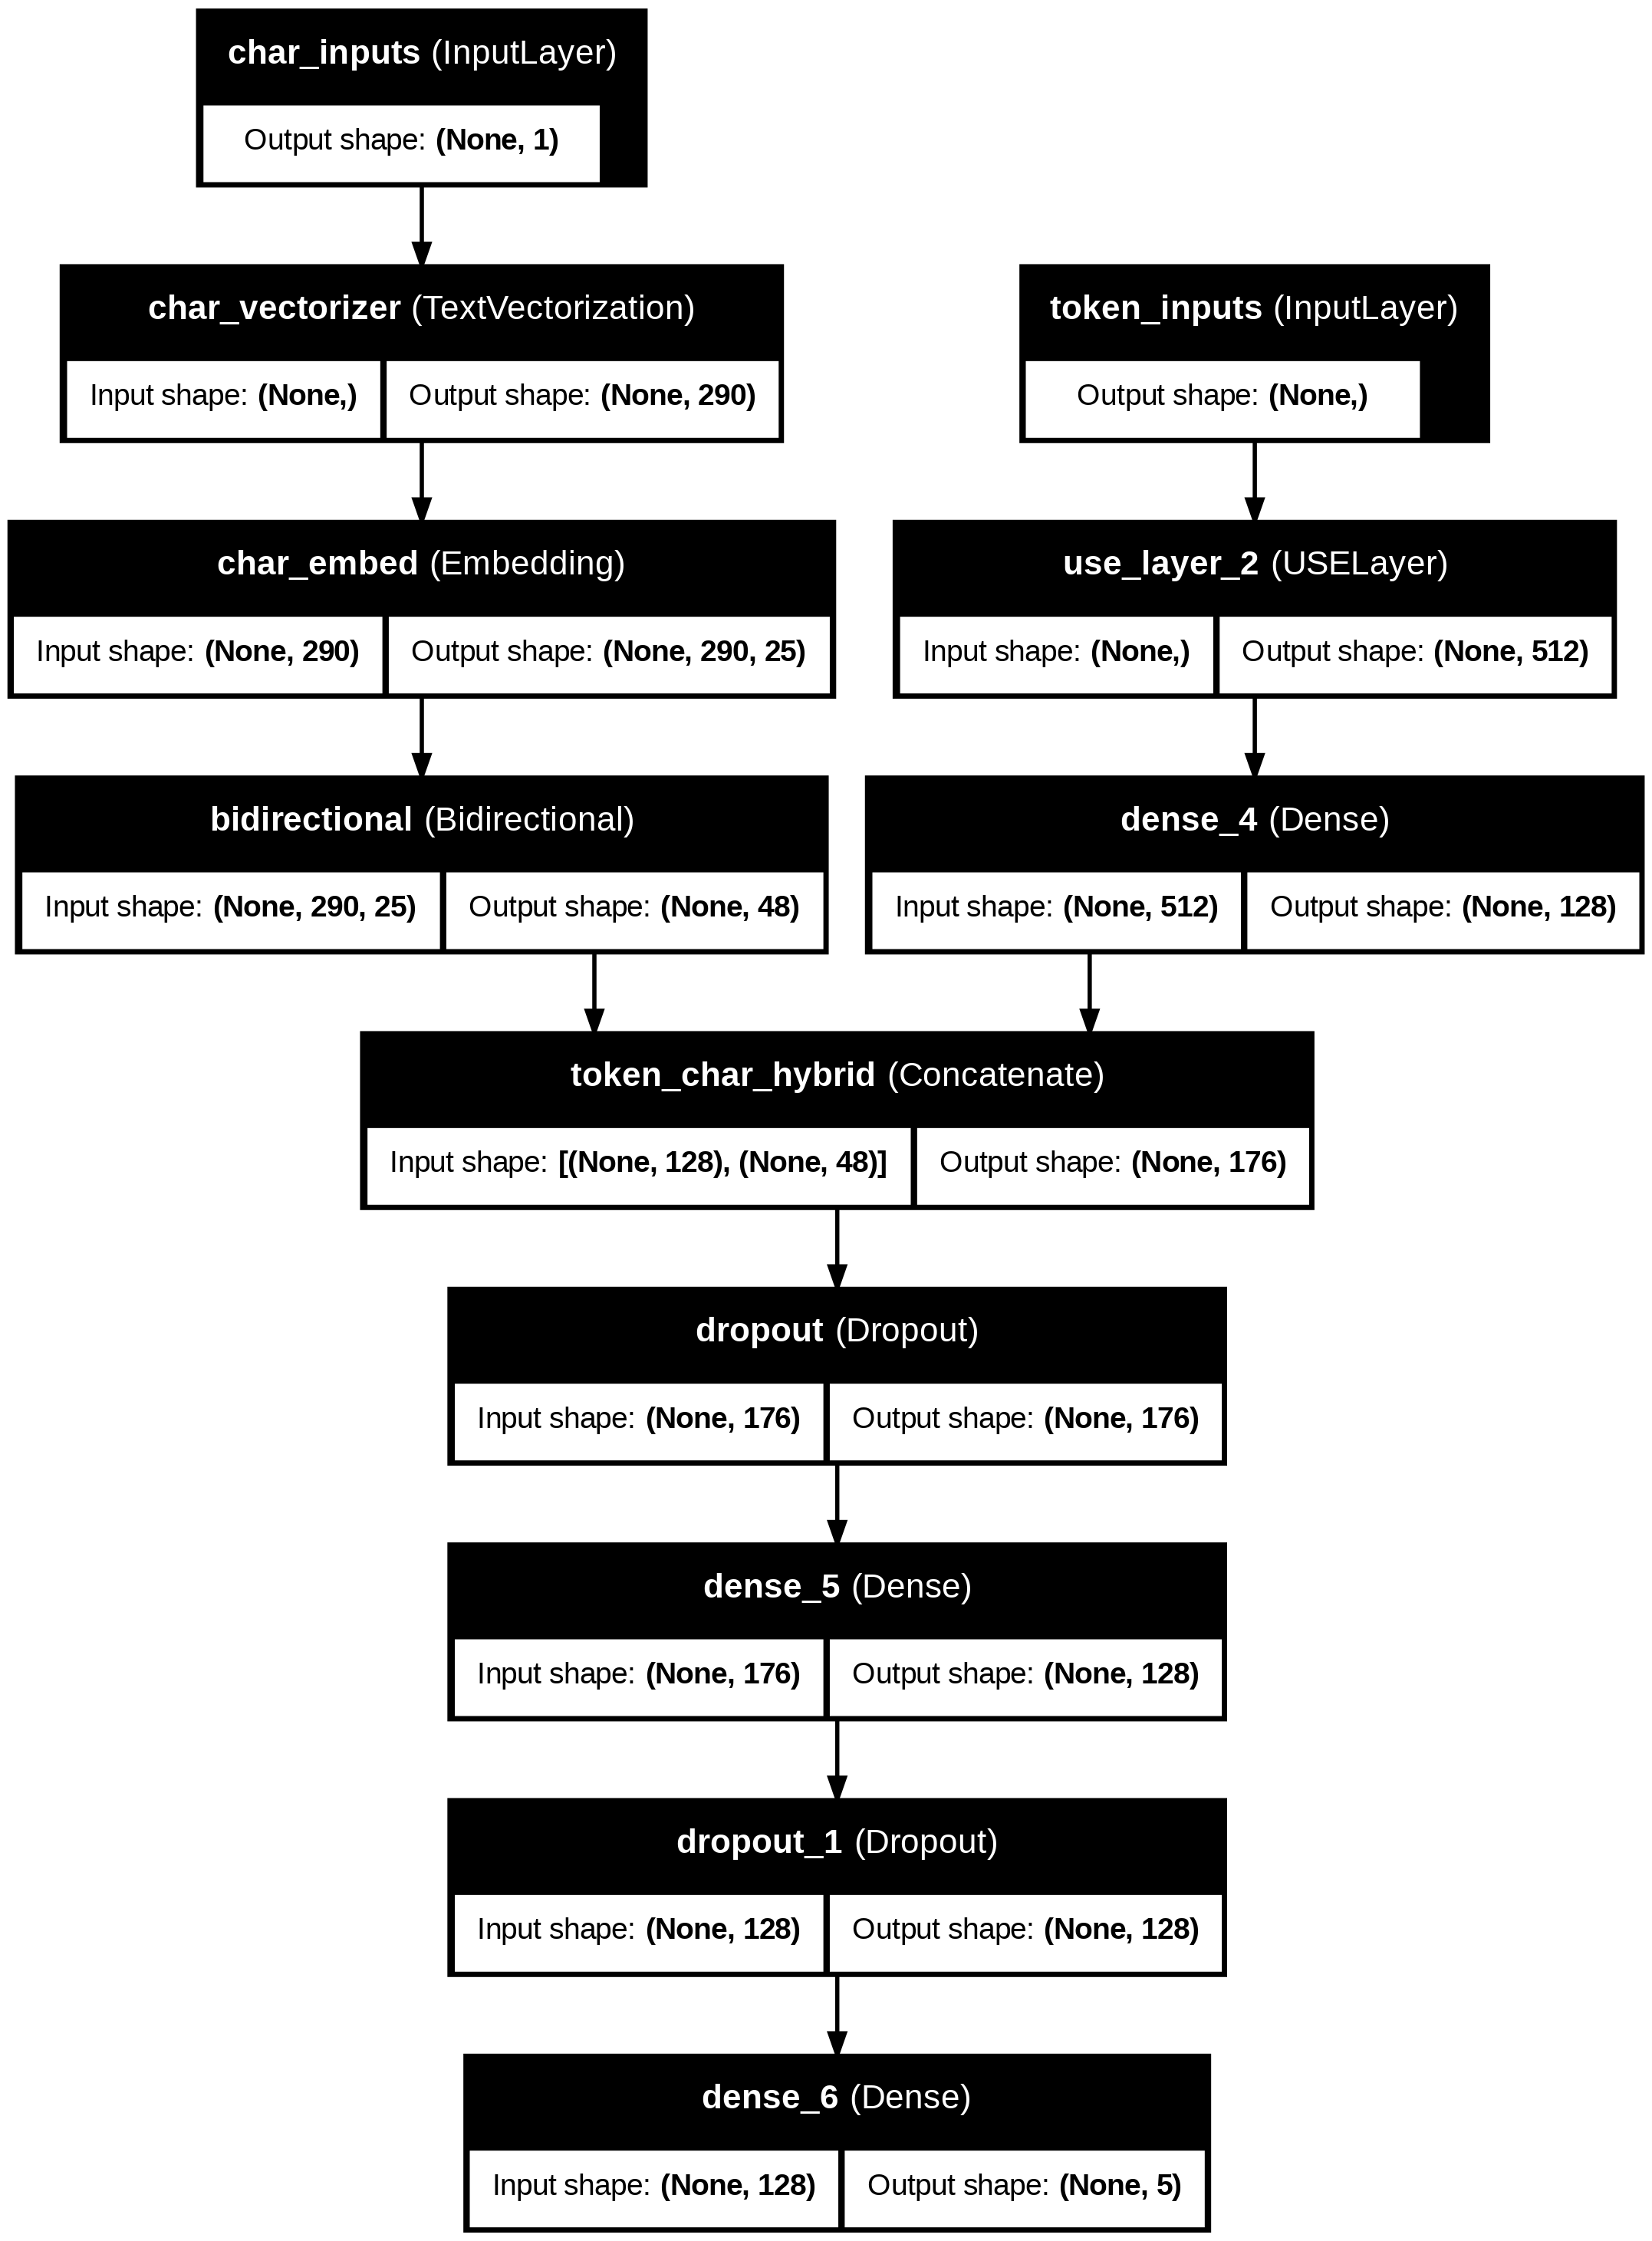

In [ ]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4,show_shapes=True,show_layer_names=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)) #make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels)) #combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars)) #make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) #make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels)) #combine data and labels

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out out training char token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

**Note:** The order to the data created in the dataset need to be on the same order of the inputs in our model.

### Fitting a model on token and character-level sequences

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.5169 - loss: 1.1633 - val_accuracy: 0.6932 - val_loss: 0.7861
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.6884 - loss: 0.8119 - val_accuracy: 0.7307 - val_loss: 0.7208
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.6988 - loss: 0.7837 - val_accuracy: 0.7420 - val_loss: 0.6938


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.7331 - loss: 0.7010


[0.7018556594848633, 0.7329537868499756]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step


array([[4.1310665e-01, 3.7019891e-01, 4.4989949e-03, 2.0427510e-01,
        7.9203574e-03],
       [3.2741293e-01, 4.8031729e-01, 3.5342735e-03, 1.8610443e-01,
        2.6309942e-03],
       [3.1948668e-01, 1.4860605e-01, 4.3142829e-02, 4.6294394e-01,
        2.5820574e-02],
       ...,
       [6.1705138e-04, 9.6059805e-03, 5.8036815e-02, 1.8503264e-04,
        9.3155509e-01],
       [8.0369059e-03, 5.8239967e-02, 1.8965411e-01, 3.4506754e-03,
        7.4061835e-01],
       [2.6545009e-01, 3.7537396e-01, 2.3892455e-01, 3.6567844e-02,
        8.3683543e-02]], dtype=float32)

**Note:** If we want to get the best performance in the model, in the future we will have to do the predictions using the same format as validation dataset

In [ ]:
# Format pred probs into pred labels

model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Get resulta of token-char hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.2953793194757,
 'precision': 0.7333413300591389,
 'recall': 0.7329537931947571,
 'f1': 0.7303245057848722}

## Model 5: Transfer Learning with pretrained token embeddings + chracter embeddings + positional embedding

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any enineered feature used to train a model need to be available at test time. In our case, line numbers and total lines ara available.

### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

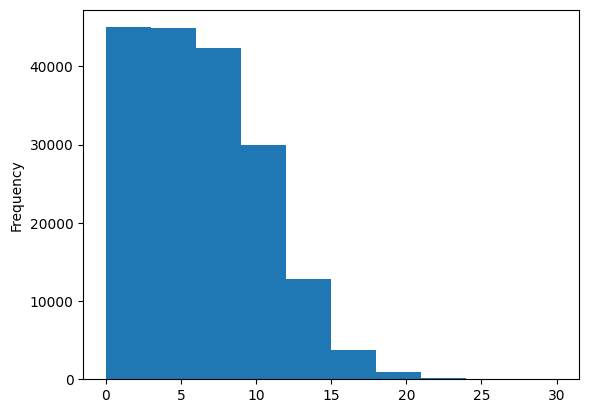

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_total_lines_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
#How many differents number of lines are there?
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

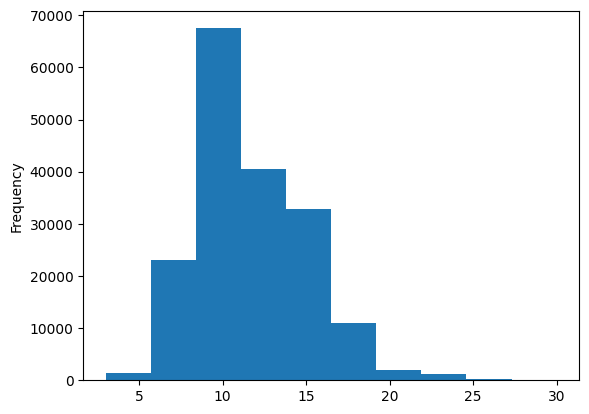

In [ ]:
# check the distribution of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of a "total_lines"
percentile_total_lines = np.percentile(train_df["total_lines"],95)
percentile_total_lines

np.float64(18.0)

In [ ]:
# Use Tensorflow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=percentile_total_lines)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=percentile_total_lines)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=percentile_total_lines)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 18]),
 <tf.Tensor: shape=(10, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.]], dtype=floa

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs the 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [ ]:
train_line_numbers_one_hot[0].shape,train_line_numbers_one_hot[0].dtype

(TensorShape([15]), tf.float32)

In [ ]:
train_total_lines_one_hot[0].shape,train_total_lines_one_hot[0].dtype

(TensorShape([18]), tf.float32)

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype="string",name="token_inputs")
token_embeddings = USELayer()(token_inputs) # USE layer used in the model 4 for to use the pretrained model as layer
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,),dtype="string",name="char_inputs")
char_embeddings = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_embeddings)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_bi_lstm)

# 3. line_number model
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32,name="line_number_inputs") # the shape is 15 because is the shape of our encoded data
x = layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,outputs=x)

# 4. Total lines model

total_lines_inputs = layers.Input(shape=(18,),dtype=tf.float32,name="total_lines_inputs")
y = layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

# 5. Combine token and char embeddings into hybrid  embeddings
combine_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256,activation="relu")(combine_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine  positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="tribrid_embedding")([line_number_model.output,
                                                                   total_lines_model.output,
                                                                   z]) # we use only z because is the tensor itself, we use the output in the other because we need the output tensor of the model


# 7. Create output layer
output_layer = layers.Dense(5,activation="softmax",name="output_layer")(tribrid_embeddings)

# 8. Create model with all kind of inputs
model_5= tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],
                        outputs=output_layer,
                        name="model_5_tribrid_embedding")


In [ ]:
# Get a summary of a tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_inputs         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_inputs        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_inputs[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ use_layer_3         │ (None, 512)       │          0 │ token_inputs[0][… │
│ (USELayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     65,664 │ use_layer_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 48)        │      9,600 │ char_embed[2][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_hybrid_… │ (None, 176)       │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_inputs  │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_inputs  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     45,312 │ char_token_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │        608 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tribrid_embedding   │ (None, 320)       │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ dense_9[0][0],    │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ tribrid_embeddin… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124,001 (484.38 KB)

 Trainable params: 124,001 (484.38 KB)

 Non-trainable params: 0 (0.00 B)

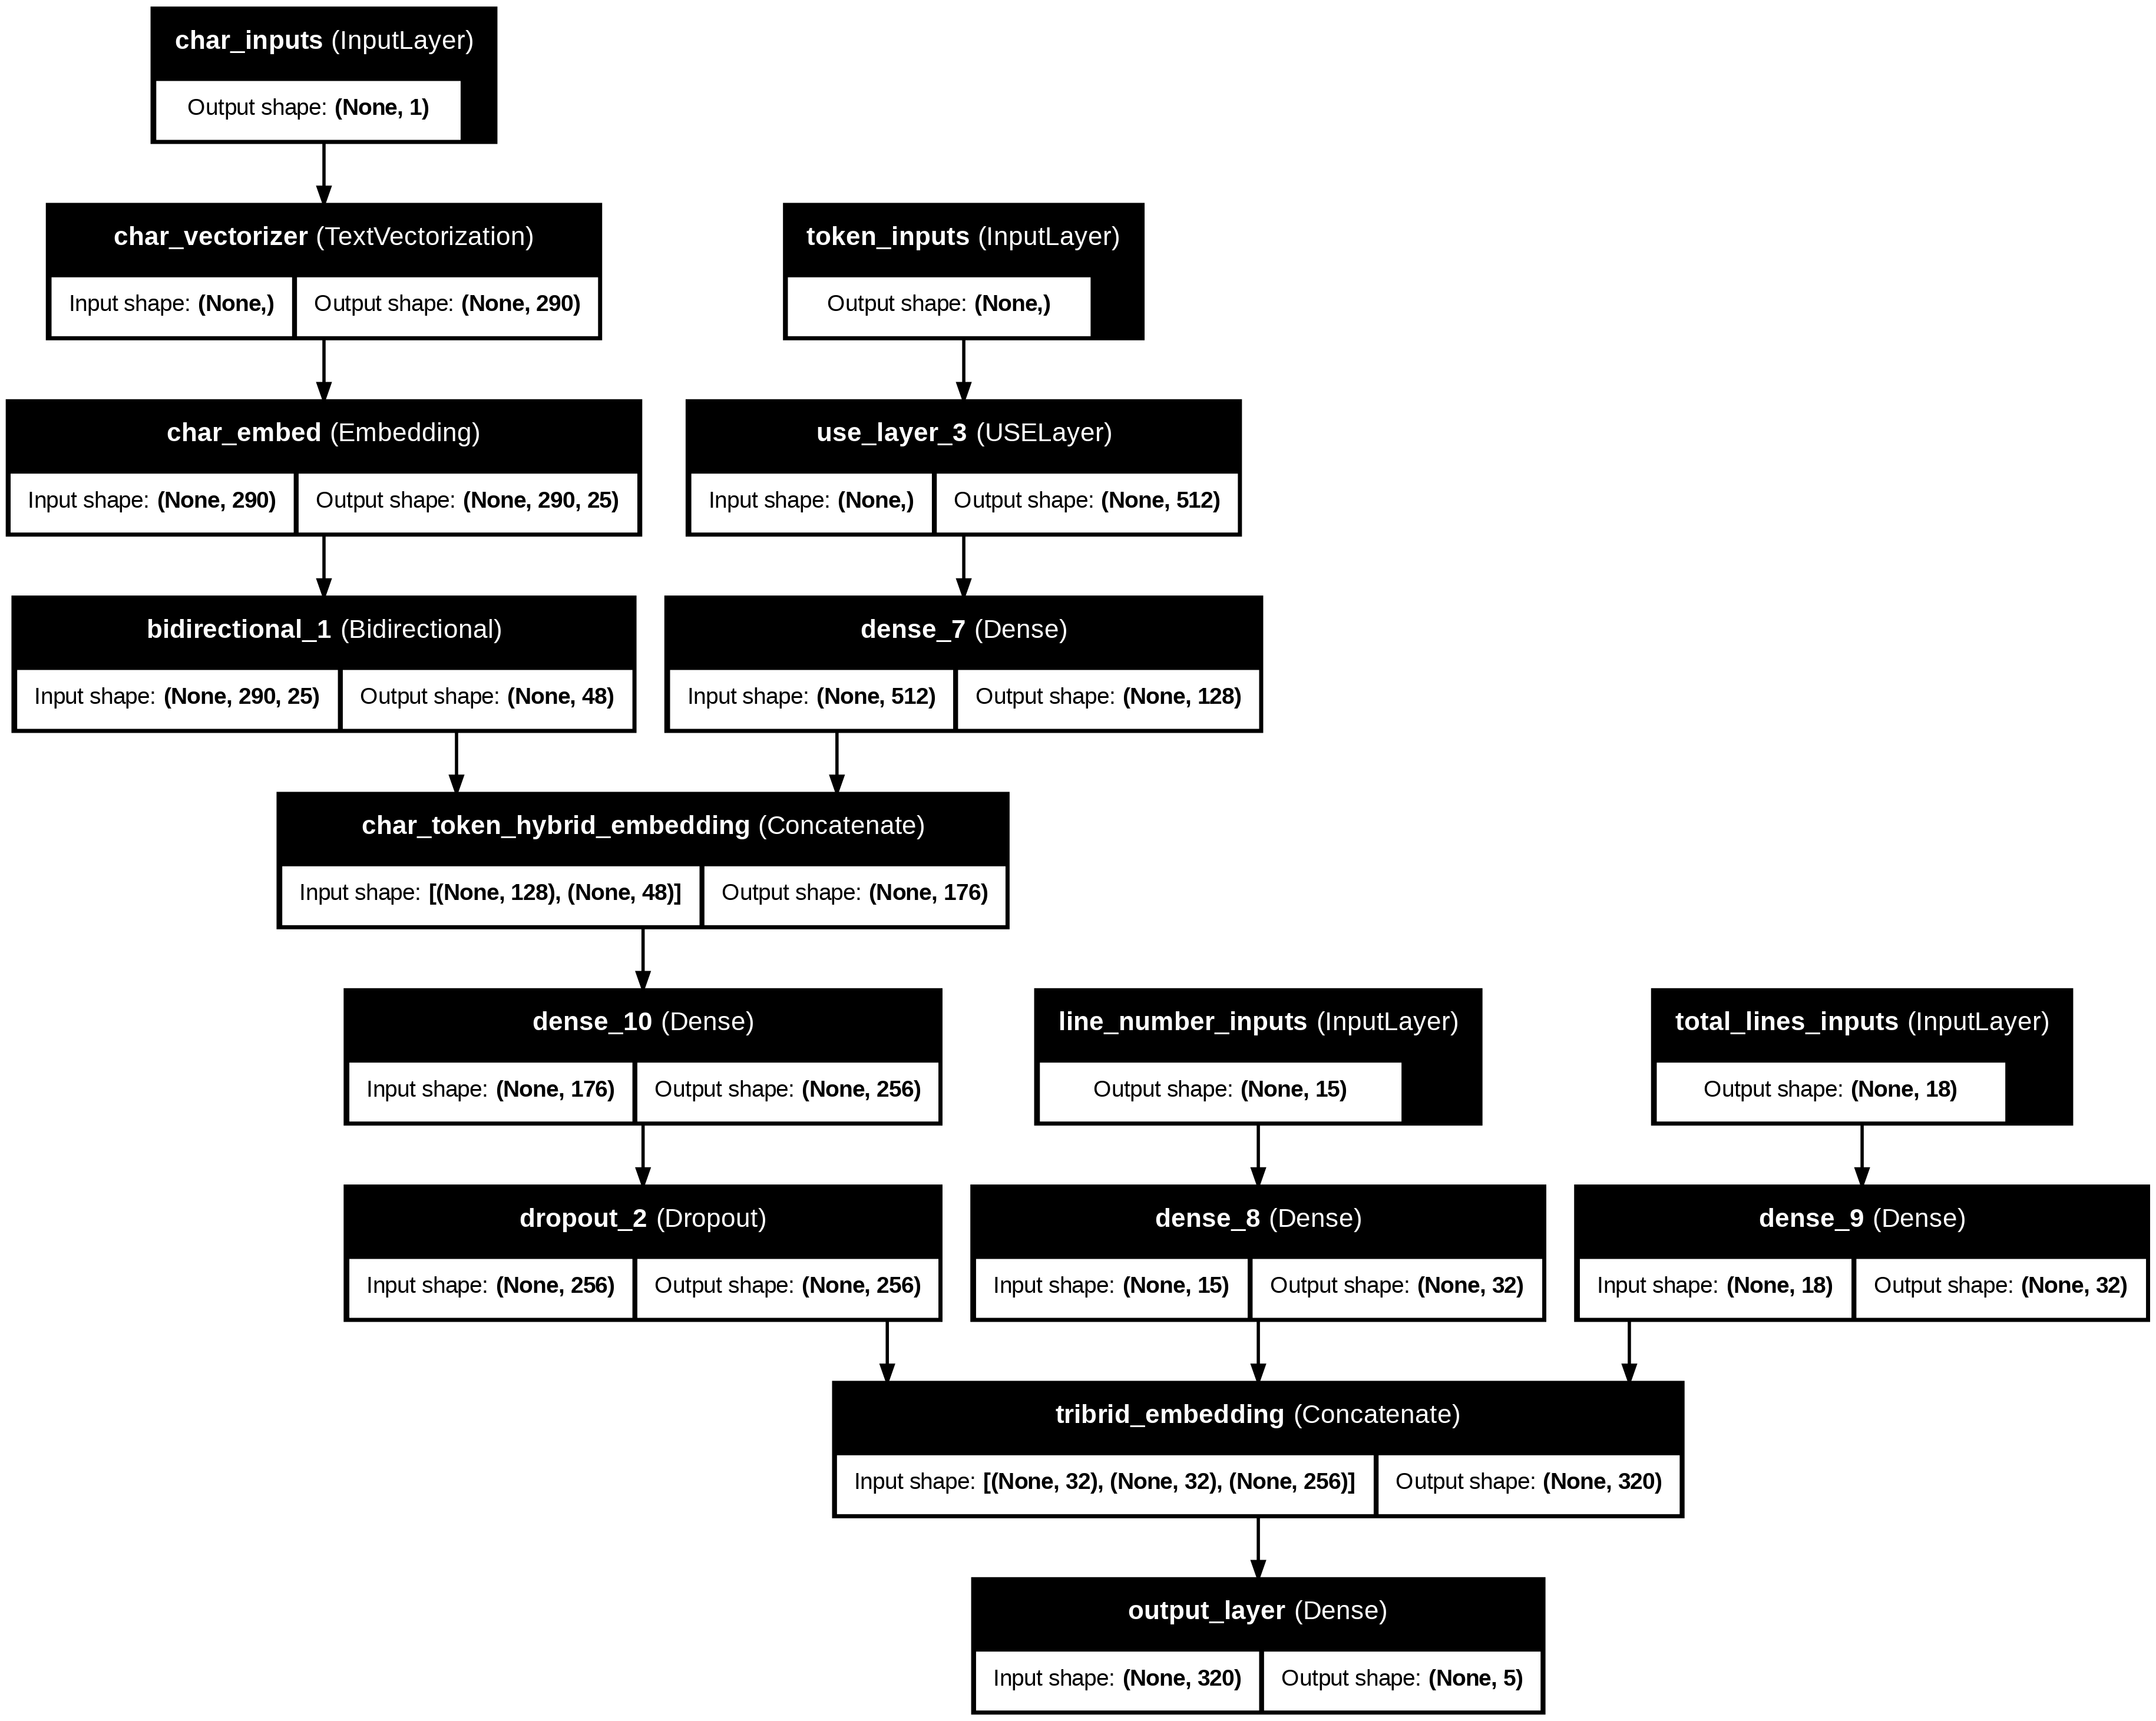

In [ ]:
# Plot model 5
tf.keras.utils.plot_model(model_5,show_shapes=True,show_layer_names=True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get  stuck on that class and not consider other classes...

Really confident: [0.0,0.0,1.0,0.0,0.0]

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: [0.01,0.01,0.96,0.01,0.01]

> For more on label smoothing: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
# Compile the  tribrid embedding model
model_5.compile(loss=tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribid embedding datasets using tf.data

In [ ]:
# Create training dataset
train_tribid_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                        train_total_lines_one_hot,
                                                        train_sentences,train_chars))

train_tribid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_tribid_dataset = tf.data.Dataset.zip((train_tribid_data,train_tribid_labels))

train_tribid_dataset = train_tribid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create validation dataset
val_tribid_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                        val_total_lines_one_hot,
                                                        val_sentences,val_chars))


val_tribid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_tribid_dataset = tf.data.Dataset.zip((val_tribid_data,val_tribid_labels))

val_tribid_dataset = val_tribid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check inputs shapes

train_tribid_dataset, val_tribid_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
train_tribid_dataset.element_spec

((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 18), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.string, name=None),
  TensorSpec(shape=(None,), dtype=tf.string, name=None)),
 TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))

### Fitting, evaluating and making predictions with our tribrid model

In [ ]:
model_5_history = model_5.fit(train_tribid_dataset,
                              steps_per_epoch = int(0.1*len(train_tribid_dataset)),
                              epochs = 3,
                              validation_data = val_tribid_dataset,
                              validation_steps = int(0.1*len(val_tribid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.6355 - loss: 0.1789 - val_accuracy: 0.8062 - val_loss: 0.1359
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8137 - loss: 0.1352 - val_accuracy: 0.8344 - val_loss: 0.1304
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.8215 - loss: 0.1322 - val_accuracy: 0.8328 - val_loss: 0.1292


In [ ]:
# Make predictions
model_5_pred_probs = model_5.predict(val_tribid_dataset)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step


array([[0.4116483 , 0.10430788, 0.02668005, 0.40944505, 0.04791868],
       [0.42193443, 0.10193472, 0.09265707, 0.35433853, 0.02913532],
       [0.29716882, 0.10759702, 0.15028515, 0.35761452, 0.08733447],
       ...,
       [0.08527344, 0.17352435, 0.08667775, 0.06684671, 0.5876778 ],
       [0.05434211, 0.32381365, 0.11179215, 0.04075962, 0.46929243],
       [0.2358915 , 0.51133806, 0.10426857, 0.05921406, 0.08928774]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate Results of tribid embedding model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.31126704620681,
 'precision': 0.8324403707225724,
 'recall': 0.833112670462068,
 'f1': 0.8326070553451788}

## Compare model results

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding":model_1_results,
                                  "moodel_2_pretrained_token_embedding":model_2_results,
                                  "model_3_char_embedding":model_3_results,
                                  "model_4_hybrid":model_4_results,
                                  "model_5_tribrid_embedding":model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,80.567324,0.804693,0.805673,0.804301
moodel_2_pretrained_token_embedding,71.273004,0.712909,0.712730,0.709790
model_3_char_embedding,66.546405,0.663359,0.665464,0.654362
model_4_hybrid,73.295379,0.733341,0.732954,0.730325
model_5_tribrid_embedding,83.311267,0.832440,0.833113,0.832607


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.805673,0.804693,0.805673,0.804301
moodel_2_pretrained_token_embedding,0.712730,0.712909,0.712730,0.709790
model_3_char_embedding,0.665464,0.663359,0.665464,0.654362
model_4_hybrid,0.732954,0.733341,0.732954,0.730325
model_5_tribrid_embedding,0.833113,0.832440,0.833113,0.832607


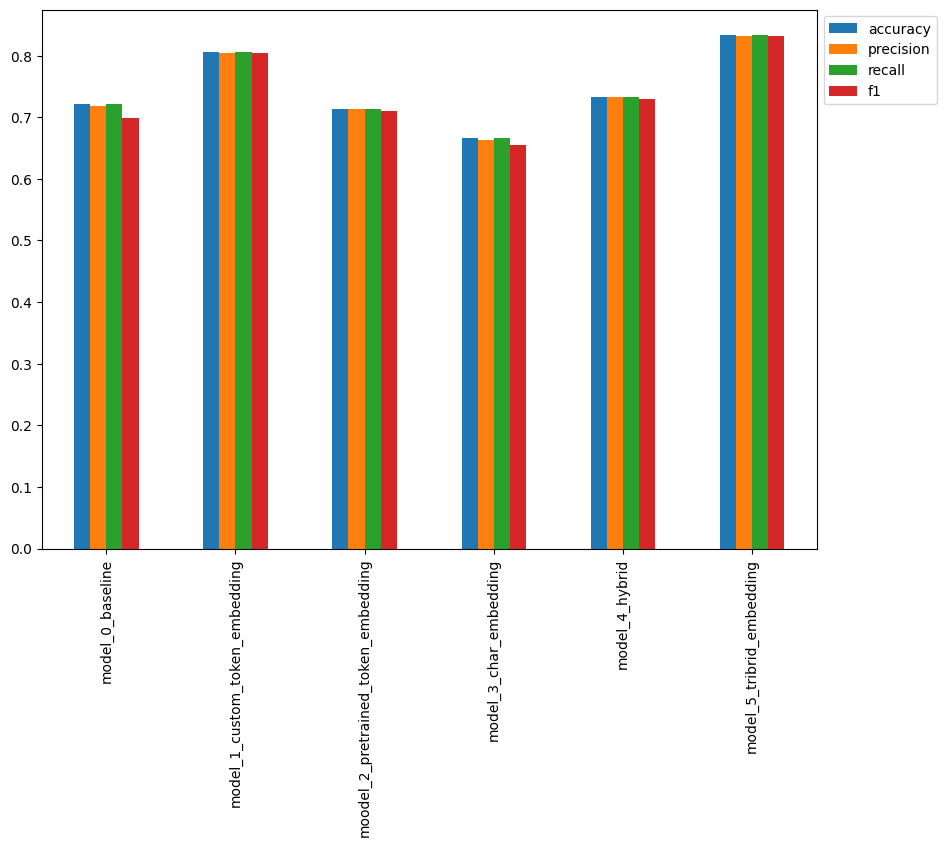

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

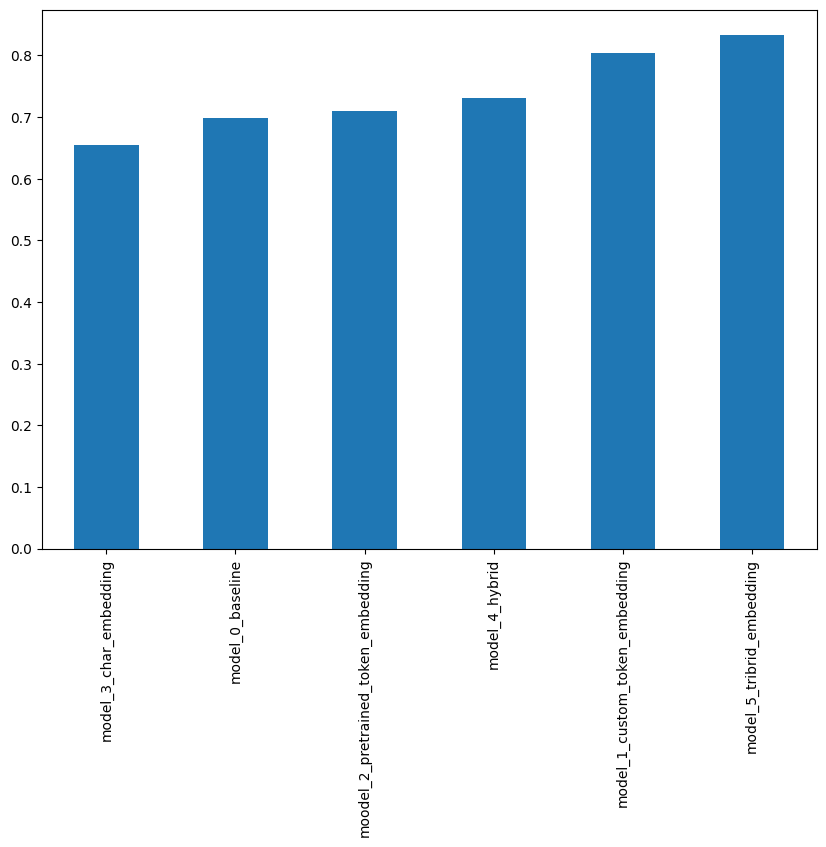

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1",ascending=True)["f1"].plot(kind="bar",figsize=(10,7))

## Save and load the model

In [ ]:
# Save the best model
model_5.save("skimlit_tribid_model.keras")

In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model("skimlit_tribid_model.keras")

In [ ]:
loaded_model_pred_probs = loaded_model.predict(val_tribid_dataset)
loaded_model_preds = tf.argmax(loaded_model_pred_probs,axis=1)
loaded_model_preds

945/945 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_model_preds)
loaded_model_results

{'accuracy': 83.31126704620681,
 'precision': 0.8324403707225724,
 'recall': 0.833112670462068,
 'f1': 0.8326070553451788}

In [ ]:
model_5_results

{'accuracy': 83.31126704620681,
 'precision': 0.8324403707225724,
 'recall': 0.833112670462068,
 'f1': 0.8326070553451788}

In [ ]:
assert model_5_results == loaded_model_results

In [ ]:
# Check the loaded model summary
loaded_model.summary()

Model: "model_5_tribrid_embedding"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_inputs         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_inputs        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_inputs[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ use_layer_3         │ (None, 512)       │          0 │ token_inputs[0][… │
│ (USELayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     65,664 │ use_layer_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 48)        │      9,600 │ char_embed[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_hybrid_… │ (None, 176)       │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_inputs  │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_inputs  │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     45,312 │ char_token_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │        608 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tribrid_embedding   │ (None, 320)       │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ dense_9[0][0],    │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ tribrid_embeddin… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 372,005 (1.42 MB)

 Trainable params: 124,001 (484.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 248,004 (968.77 KB)